##Classification of Credit Card Default Analysis

In [1]:
import matplotlib.ticker as ticker

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from IPython.display import Image  
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn import tree 
from sklearn.externals.six import StringIO  
from sklearn.tree import export_graphviz
import pydotplus
import scipy
from mpl_toolkits.mplot3d import Axes3D
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from matplotlib.pyplot import plot
from matplotlib.pyplot import figure
from matplotlib.pyplot import style
import matplotlib.ticker as mtick

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score

acc=[]
prec=[]
rec=[]

plt.rcParams["figure.figsize"] = (21,7)
plt.style.use('seaborn-white')

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


# Acquiring the dataset and performing light modifications

In [2]:
data_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vRuFNk7Bw67LDd95ljPlhFO0PmkA4c83aWp2CPglchgl9-PJUemDjctUJXBA8Ol3fHAbTKkk7b_mbXF/pub?gid=241858898&single=true&output=csv"
df = pd.read_csv(data_path)
df.shape

(30000, 25)

In [3]:
df.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,-2,-2,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,0,2,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,0,0,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,0,0,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,0,0,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


**Data Set Information:**

This research aimed at the case of customers default payments in Taiwan

**Features description:**

**LIMIT_BAL:** Amount of the given credit (NT dollar): it includes both the 

individual consumer credit and his/her family (supplementary) credit.

**SEX:** Gender (1 = male; 2 = female).

**EDUCATION:** Education (1 = graduate school; 2 = university; 3 = high 

school; 4 = others).

**MARRIAGE:** Marital status (1 = married; 2 = single; 3 = others).

**AGE:** Age (year).


**PAY_1 - PAY_6:** History of past payment. We tracked the past monthly payment records (from April to September, 2005) as follows: 

1 = the repayment status in September, 2005; 

1 = the repayment status in August, 2005; . . .; 

6 = the repayment status in April, 2005. 

The measurement scale for the repayment status is: 

-1 = pay duly; 

1 = payment delay for one month; 

2 = payment delay for two months; . . .; 

8 = payment delay for eight months; 

9 = payment delay for nine months and above.


**BILL_AMT1-BILL_AMT6:** Amount of bill statement (NT dollar). 

X12 = amount of bill statement in September, 2005; 
X13 = amount of bill statement in August, 2005; . . .; 
X17 = amount of bill statement in April, 2005.


**PAY_AMT1-PAY_AMT6:** Amount of previous payment (NT dollar).


**default.next.payment.month:** 1 = default; 0 = no default


* Converted columns into lower case

In [4]:
df.rename(columns=lambda x: x.lower(), inplace=True)

* Renamed the column to defaulter

In [5]:
df.rename(columns={'default.payment.next.month':'defaulter','marriage':'marital_status'}, inplace=True)

In [6]:
df.tail(3)

,id,limit_bal,sex,education,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,defaulter
29997,29998,30000.0,1,2,2,37,4,3,2,-1,0,0,3565.0,3356.0,2758.0,20878.0,20582.0,19357.0,0.0,0.0,22000.0,4200.0,2000.0,3100.0,1
29998,29999,80000.0,1,3,1,41,1,-1,0,0,0,-1,-1645.0,78379.0,76304.0,52774.0,11855.0,48944.0,85900.0,3409.0,1178.0,1926.0,52964.0,1804.0,1
29999,30000,50000.0,1,2,1,46,0,0,0,0,0,0,47929.0,48905.0,49764.0,36535.0,32428.0,15313.0,2078.0,1800.0,1430.0,1000.0,1000.0,1000.0,1


* Checked the missing values by calculating the percentage

In [7]:
total = df.isnull().sum().sort_values(ascending = False)
percent = (df.isnull().sum()/df.isnull().count()*100).sort_values(ascending = False)
pd.concat([total, percent], axis=1, keys=['Total', 'Percent']).transpose()

,defaulter,pay_6,limit_bal,sex,education,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,bill_amt1,pay_amt6,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,id
Total,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Percent,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


* no missing values hence no imputation

# Explore numerical features

* Cumulated bill amount and pay amount and then assigned numerical columns to numerical_features

In [8]:
bill_amt_features = ['bill_amt'+ str(i) for i in range(1,7)]
pay_amt_features = ['pay_amt'+ str(i) for i in range(1,7)]
numerical_features = ['limit_bal','age'] + bill_amt_features + pay_amt_features

In [9]:
numerical_features

['limit_bal',
 'age',
 'bill_amt1',
 'bill_amt2',
 'bill_amt3',
 'bill_amt4',
 'bill_amt5',
 'bill_amt6',
 'pay_amt1',
 'pay_amt2',
 'pay_amt3',
 'pay_amt4',
 'pay_amt5',
 'pay_amt6']

In [10]:
df.describe()

,id,limit_bal,sex,education,marital_status,age,pay_0,pay_2,pay_3,pay_4,pay_5,pay_6,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6,defaulter
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,15000.500000,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,8660.398374,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,1.000000,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,7500.750000,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,15000.500000,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,22500.250000,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,30000.000000,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


In [11]:
df[['limit_bal','age']].describe()

,limit_bal,age
count,30000.000000,30000.000000
mean,167484.322667,35.485500
std,129747.661567,9.217904
min,10000.000000,21.000000
25%,50000.000000,28.000000
50%,140000.000000,34.000000
75%,240000.000000,41.000000
max,1000000.000000,79.000000


In [12]:
df[bill_amt_features].describe().round()

,bill_amt1,bill_amt2,bill_amt3,bill_amt4,bill_amt5,bill_amt6
count,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0
mean,51223.0,49179.0,47013.0,43263.0,40311.0,38872.0
std,73636.0,71174.0,69349.0,64333.0,60797.0,59554.0
min,-165580.0,-69777.0,-157264.0,-170000.0,-81334.0,-339603.0
25%,3559.0,2985.0,2666.0,2327.0,1763.0,1256.0
50%,22382.0,21200.0,20088.0,19052.0,18104.0,17071.0
75%,67091.0,64006.0,60165.0,54506.0,50190.0,49198.0
max,964511.0,983931.0,1664089.0,891586.0,927171.0,961664.0


In [13]:
df[pay_amt_features].describe().round()

,pay_amt1,pay_amt2,pay_amt3,pay_amt4,pay_amt5,pay_amt6
count,30000.0,30000.0,30000.0,30000.0,30000.0,30000.0
mean,5664.0,5921.0,5226.0,4826.0,4799.0,5216.0
std,16563.0,23041.0,17607.0,15666.0,15278.0,17777.0
min,0.0,0.0,0.0,0.0,0.0,0.0
25%,1000.0,833.0,390.0,296.0,252.0,118.0
50%,2100.0,2009.0,1800.0,1500.0,1500.0,1500.0
75%,5006.0,5000.0,4505.0,4013.0,4032.0,4000.0
max,873552.0,1684259.0,896040.0,621000.0,426529.0,528666.0


* Before moving to visualization we first select some features which we feel would be most correlated to the target variable. From the data provided we see that we want to predict whether a person will default in payment next month or not. This prediction depends mostly on previous repayment history, what is the limiting balance, age, education and marriage. Let's plot these first

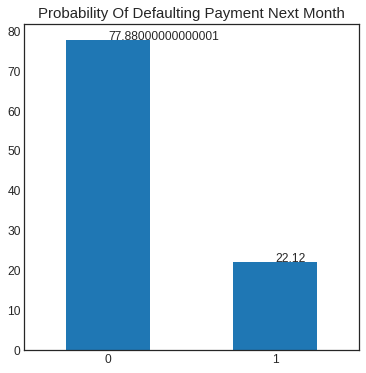

In [14]:
def_cnt = (df.defaulter.value_counts(normalize=True)*100)
def_cnt.plot.bar(figsize=(6,6))
plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=12)
plt.title('Probability Of Defaulting Payment Next Month', fontsize=15)
for x,y in zip([0,1],def_cnt):
    plt.text(x,y,y,fontsize=12)
plt.show()

* We can see that the dataset consists of 77% clients are not expected to default payment whereas 23% clients are expected to default the payment

# Visualization of numerical_features

Continuous Variables Visualization 



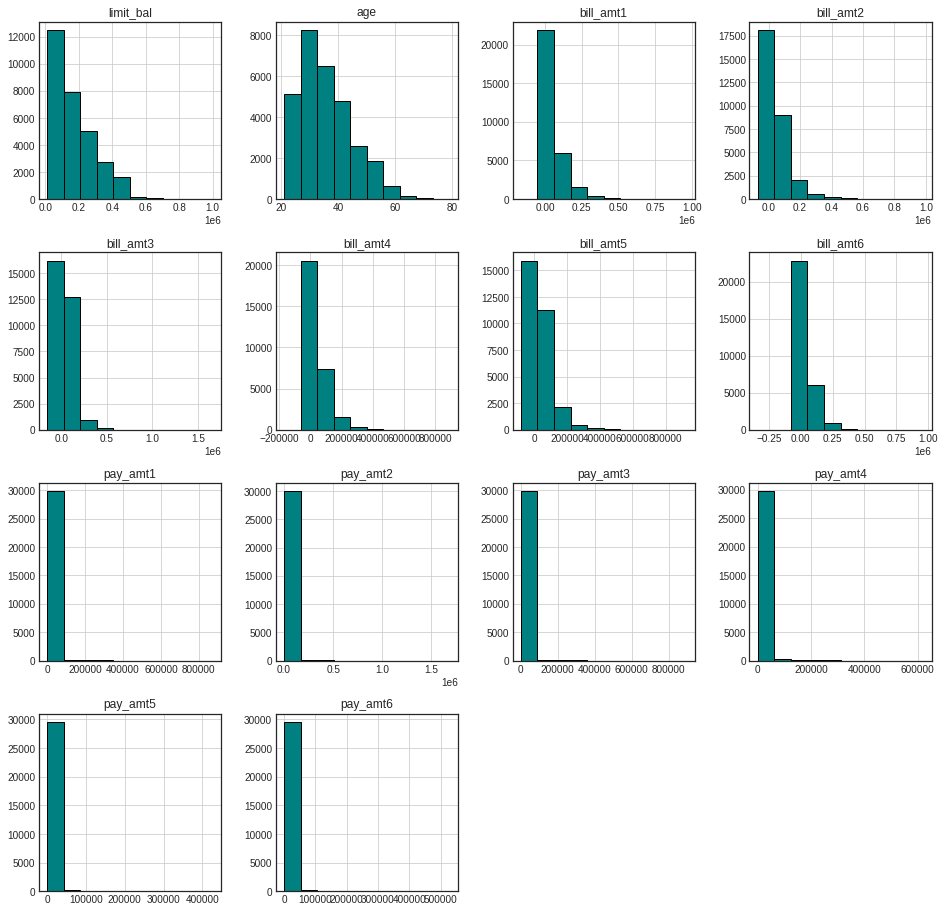

In [15]:
print('Continuous Variables Visualization','\n')
df.hist(column=numerical_features,figsize=(16,16),color='teal',edgecolor='black')
plt.show()

* Bill amount is changing for every month but pay amount remains consistent

#Described categorical features

In [16]:
categorical = ['sex', 'education', 'marital_status']

Visualization of categorical features:
 
 * Sex - Male clients are lesser in number compared to females

 * Education - More clients are persuing education in university than in school or  high school

 * Marriage - The ratio of singles are more compared to other marital status

Categorical Variables Visualization 



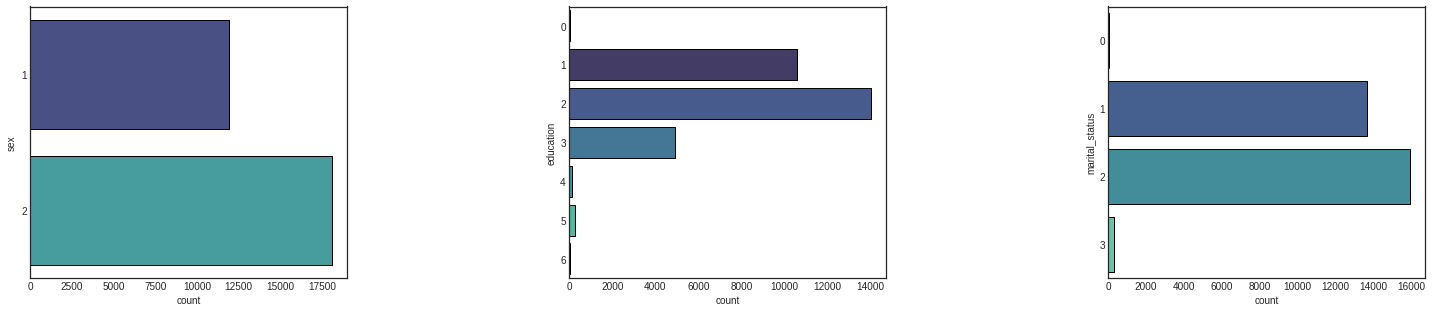

In [17]:
print('Categorical Variables Visualization','\n')
fig, axes = plt.subplots(1, 3, figsize=(25, 5))
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.7, hspace=0.3)
for i, ax in enumerate(axes.ravel()):
    if i > 3:
        ax.set_visible(False)
        continue
    sns.countplot(y = categorical[i], data=df, ax=ax,palette='mako',edgecolor='black')
plt.show()

* Transactions done by females were more compared to males
* Most of the transactions were done by the university going students than others
* Singles has done more transactions compared to other marital status

Text(0.5, 1.0, 'Age groups')

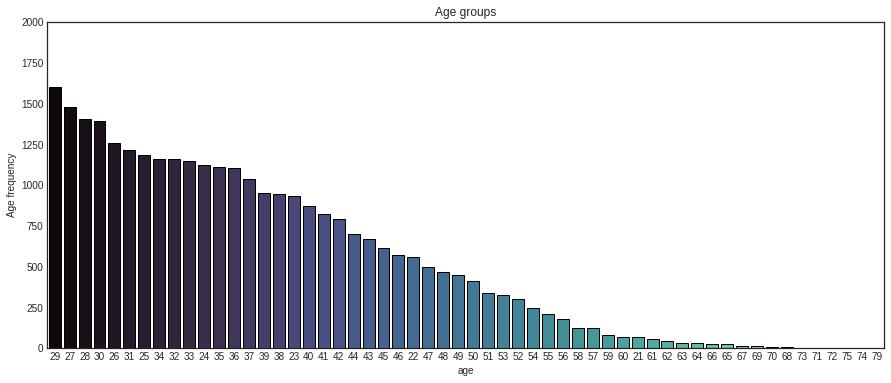

In [18]:
plt.figure(figsize=(15,6))
sns.countplot(data=df,x='age',order=df.age.value_counts().index, palette='mako',edgecolor='black')
plt.ylim(0,2000)
plt.ylabel('Age frequency')
plt.title('Age groups')

* We have maximum clients from 21-30 age group followed by 31-40. Hence with increasing age group the number of clients that will default the payment next month is decreasing.Hence we can see that Age is the important feature to predict the default payment for next month

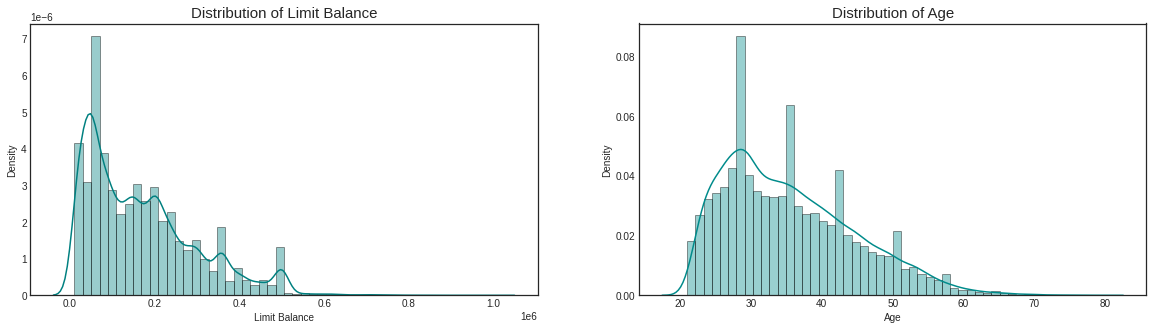

In [19]:
plt.subplots(figsize=(20,5))
plt.subplot(121)
sns.distplot(df.limit_bal,color='teal', hist_kws= dict(edgecolor='black'))
plt.title('Distribution of Limit Balance',fontsize=15)
plt.xlabel('Limit Balance')
plt.ylabel('Density')

plt.subplot(122)
sns.distplot(df.age,color='darkcyan', hist_kws= dict(edgecolor='black'))
plt.title('Distribution of Age', fontsize=15)
plt.xlabel('Age')
plt.ylabel('Density')


plt.show()

* By plotting the continous variables we observe that dataset consists of skewed data of limiting balance and age of the clients
* We have more number of clients having limiting balance between 0 to 200000 currency
* We have more number of clients from age bracket of 20 to 40, i.e., clients from mostly young to mid aged groups
* We will observe the effect of variables on target variable below

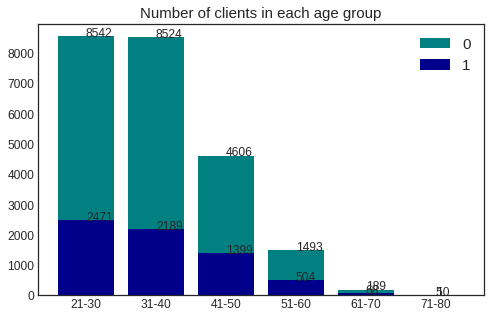

In [20]:
bins = [20,30,40,50,60,70,80]
names = ['21-30','31-40','41-50','51-60','61-70','71-80']
df['age_bin'] = pd.cut(x=df.age, bins=bins, labels=names, right=True)

age_cnt = df.age_bin.value_counts()
age_0 = (df.age_bin[df['defaulter'] == 0].value_counts())
age_1 = (df.age_bin[df['defaulter'] == 1].value_counts())

plt.subplots(figsize=(8,5))
plt.bar(age_0.index, age_0.values, label='0',color='teal')
plt.bar(age_1.index, age_1.values, label='1',color='darkblue')
for x,y in zip(names,age_0):
    plt.text(x,y,y,fontsize=12)
for x,y in zip(names,age_1):
    plt.text(x,y,y,fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.title('Number of clients in each age group', fontsize=15)
plt.legend(loc='upper right', fontsize=15)
plt.show()

# Logistic Regression

In [21]:
df_X = df.drop(['defaulter','age_bin'], axis=1)
df_y = df.defaulter

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.2, random_state=10)

model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [22]:
y_pred = model.predict(X_test)

In [23]:
acc.append(model.score(X_test, y_test))
rec.append(recall_score(y_test,y_pred))
prec.append(precision_score(y_test,y_pred))

In [24]:
print(classification_report(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))
print('\nAccuracy Score for model1: ', accuracy_score(y_pred,y_test))

              precision    recall  f1-score   support

           0       1.00      0.78      0.88      5998
           1       0.00      0.00      0.00         2

    accuracy                           0.78      6000
   macro avg       0.50      0.39      0.44      6000
weighted avg       1.00      0.78      0.88      6000

[[4681 1317]
 [   2    0]]

Accuracy Score for model1:  0.7801666666666667


In [25]:
#try to use different features to train the model
df_X = df[['sex','marital_status','age','bill_amt1','education','pay_0']]
df_y = df.defaulter

X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.3, random_state=20)

ridge = RidgeClassifier()
ridge.fit(X_train, y_train)

y_pred = ridge.predict(X_test)
y_train_pred = ridge.predict(X_train)

print(classification_report(y_pred, y_test))
print(confusion_matrix(y_pred, y_test))
print('\nTest Accuracy Score for model5: ', accuracy_score(y_pred,y_test))
print('\nTrain Accuracy Score for model5: ', accuracy_score(y_train_pred,y_train))

              precision    recall  f1-score   support

           0       0.99      0.79      0.88      8694
           1       0.11      0.70      0.18       306

    accuracy                           0.79      9000
   macro avg       0.55      0.75      0.53      9000
weighted avg       0.96      0.79      0.86      9000

[[6910 1784]
 [  93  213]]

Test Accuracy Score for model5:  0.7914444444444444

Train Accuracy Score for model5:  0.7915238095238095


#Outcomes:

We performed logistic regression combining different variables to predict the defaulters. The performance of regression model gives 78% accuracy score.

Finally, the most effective results from variables that are contributing to know the default payments are 'sex', 'marital_status', 'age', 'bill_amt1', 'education', 'pay_0'.

The final accuracy score of the model has improved to 79%. 

#Other Analysis:

To compare the Logistic regression with other model, further we performed Random forest classifier. 

This will help us predicting the rate of default in payments according to the different parameters to increase the accuracy rate.

#Random Forest Classifier

In [26]:
X = df.drop(columns=['defaulter','age_bin'],axis=1).values
y = df['defaulter'].values
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=6, stratify=y)

In [27]:
#Setup arrays to store training and test accuracies
nestimators = np.arange(start=1, stop=100, step=5)
train_accuracy =np.empty(len(nestimators))
test_accuracy = np.empty(len(nestimators))

for i,k in enumerate(nestimators):
    #Setup a Random Forest Classifier with k estimators
    rfc = RandomForestClassifier(n_estimators=k)
    
    #Fit the model
    rfc.fit(X_train, y_train)
    
    #Compute accuracy on the training set
    train_accuracy[i] = rfc.score(X_train, y_train)
    
    #Compute accuracy on the test set
    test_accuracy[i] = rfc.score(X_test, y_test)

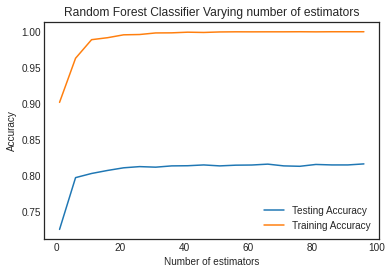

In [28]:
#Generate plot
plt.title('Random Forest Classifier Varying number of estimators')
plt.plot(nestimators, test_accuracy, label='Testing Accuracy')
plt.plot(nestimators, train_accuracy, label='Training Accuracy')
plt.legend()
plt.xlabel('Number of estimators')
plt.ylabel('Accuracy')
plt.show()

In [29]:
#Setup a Random Forest Classifier with n_estimators=10
rfc = RandomForestClassifier(n_estimators=10,random_state=10)  
#Fit the model
rfc.fit(X_train, y_train)
#accuracy on the test set
test_accuracy = rfc.score(X_test, y_test)

y_pred = rfc.predict(X_test)

acc.append(rfc.score(X_test, y_test))
rec.append(recall_score(y_test,y_pred))
prec.append(precision_score(y_test,y_pred))

In [30]:
confusion_matrix(y_test,y_pred)
#True Negatives: 6613 and True Positives: 614

array([[6613,  396],
       [1377,  614]])

In [31]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7009
           1       0.61      0.31      0.41      1991

    accuracy                           0.80      9000
   macro avg       0.72      0.63      0.65      9000
weighted avg       0.78      0.80      0.78      9000



In [32]:
rfc.score(X_test,y_test)

0.803

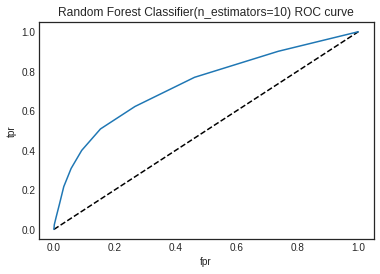

In [33]:
y_pred_proba = rfc.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='RFC')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Random Forest Classifier(n_estimators=10) ROC curve')
plt.show()

In [34]:
roc_auc_score(y_test,y_pred_proba)

0.7302860374897195

#Grid-Search

In [35]:
#In case of classifier like Random Forest the parameter to be tuned is n_estimators
param_grid = {'n_estimators':np.arange(1,30)}
rfc2 = RandomForestClassifier()
rfc_cv= GridSearchCV(rfc2,param_grid,cv=5)
rfc_cv.fit(X,y)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              rando

In [36]:
#Grid Search:
print(rfc_cv.best_score_)
print(rfc_cv.best_params_)

0.8126333333333333
{'n_estimators': 25}


# Re-run with optimal settings

In [37]:
rfc3 = RandomForestClassifier(n_estimators=29, random_state=10)
rfc3.fit(X_train,y_train)

acc.append(rfc3.score(X_test, y_test))
rec.append(recall_score(y_test,y_pred))
prec.append(precision_score(y_test,y_pred))

print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.83      0.94      0.88      7009
           1       0.61      0.31      0.41      1991

    accuracy                           0.80      9000
   macro avg       0.72      0.63      0.65      9000
weighted avg       0.78      0.80      0.78      9000



In [38]:
rfc3.score(X_test,y_test)

0.8096666666666666

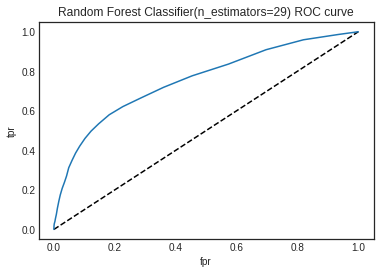

0.7536877856474838

In [39]:
y_pred_proba2 = rfc3.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba2)
plt.plot([0,1],[0,1],'k--')
plt.plot(fpr,tpr, label='Knn')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('Random Forest Classifier(n_estimators=29) ROC curve')
plt.show()
roc_auc_score(y_test,y_pred_proba2)

# Model Compare

What are the parameter configurations?

* we are using all the variables in the dataset for X except default.payment.next.month variable and Y consists only default.payment.next.month variable

* For the RFC, the number of estimators are 10 

* For the tuned RFC, the number of estimators are 28

What are the technical performance criteria?

In [41]:
d={'Accuracy':acc,'Precision':prec,'Recall':rec}
res = pd.DataFrame(d)
res.index=['Logistic Regression','RFC','Tuned RFC']
res

,Accuracy,Precision,Recall
Logistic Regression,0.780167,0.000000,0.000000
RFC,0.803000,0.607921,0.308388
Tuned RFC,0.809667,0.607921,0.308388


In [42]:
res

,Accuracy,Precision,Recall
Logistic Regression,0.780167,0.000000,0.000000
RFC,0.803000,0.607921,0.308388
Tuned RFC,0.809667,0.607921,0.308388


In [43]:
LR=[acc[0],prec[0],rec[0]]
RFC=[acc[1],prec[1],rec[1]]
TRFC=[acc[2],prec[2],rec[2]]
a={'LR':LR,'RFC':RFC,'Tuned RFC':TRFC}
res1=pd.DataFrame(a)
res1.index=['Accuracy','Precision','Recall']
res1

,LR,RFC,Tuned RFC
Accuracy,0.780167,0.803000,0.809667
Precision,0.000000,0.607921,0.607921
Recall,0.000000,0.308388,0.308388


The top 3 performing models are Logistic classifier, Random forest classifier and Tuned random forest classifier

#Predict 5 values for X’s that are not in the data set

In [44]:
data_path = "https://docs.google.com/spreadsheets/d/e/2PACX-1vT2bftXaEerVfBZr0aTK-jBr7lYmWnaDJqPjO3o98ZhAst0vLi7s4S3EfPnxzEu6mPh2sG55yDUTI-x/pub?gid=1194537295&single=true&output=csv"
newdata = pd.read_csv(data_path)
newdata.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,50000.0,1,1,2,57,-1,0,-1,-1,0,0,8617,5670,35835,20940,19146,19131,2000,6681,10000,9000,532,679,NaN
1,2,630000.0,1,2,1,25,-1,0,0,-1,0,0,11285,14096,12108,12211,11793,3719,3329,0,432,1000,1000,1000,NaN
2,3,180000.0,1,2,1,36,2,2,-2,-2,-2,-2,83538,0,0,0,0,0,0,0,0,0,0,0,NaN
3,4,100000.0,2,2,2,23,0,-1,-1,0,0,-1,38358,27688,18463,20616,11802,930,3000,1537,1000,2000,930,33764,NaN
4,5,60000.0,1,1,2,27,1,-2,-1,-1,-1,-1,-109,-425,259,-57,127,-189,0,1000,0,500,0,1000,NaN


In [45]:
newdata= newdata.drop(columns=['default.payment.next.month'],axis=1).values

In [46]:
newdata_X = newdata
y_pred_lr = model.predict(newdata_X)
y_pred_rfc = rfc.predict(newdata_X)
y_pred_tuned_rfc = rfc3.predict(newdata_X)

In [47]:
pre_result=pd.DataFrame(data=y_pred_rfc,columns=['Logistic Classifier'])

In [48]:
pre_result['Random Forest Classifier']=y_pred_rfc
pre_result['Tuned Random Forest Classifier']=y_pred_tuned_rfc

In [49]:
pre_result

,Logistic Classifier,Random Forest Classifier,Tuned Random Forest Classifier
0,0,0,0
1,0,0,0
2,1,1,1
3,0,0,0
4,1,1,1


A new dataset was made up to test the accuracy of the models. All the three models gave the same predictions

#Explains the implications of the results and how they might be used

From the above model results, 


This model can be used to predict the default payments in future. By knowing various variables like sex, marital status, education, age etc., the credit card company can decide whether to give the credit card to the customer or not.

In case they know that there are high chances of default, they can choose to increase the interest for that particular customer